Идея - встраивание стего-изображения в контейнер-изображение при помощи GAN
1. Конвертация изображения в YCrCb
2. Хаотичная перестановка пикселей
3. Нейросеть для скрытия и извлечения изображения
4. Дискриминатор для сравнения встраиваемого изображения от восстановленного

In [67]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [68]:
def rgb_to_ycrcb(image_rgb):
    """ Convert RGB tensor to YCrCb tensor """
    r = image_rgb[0, :, :]
    g = image_rgb[1, :, :]
    b = image_rgb[2, :, :]
    
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cr = 0.5 * (r - y) * 0.713 + 128/255
    cb = 0.5 * (b - y) * 0.564 + 128/255
    
    return torch.stack([y, cr, cb], dim=0)

def ycrcb_to_rgb(image_ycrcb):
    """ Convert YCrCb tensor to RGB tensor """
    y = image_ycrcb[0, :, :]
    cr = image_ycrcb[1, :, :]
    cb = image_ycrcb[2, :, :]
    
    r = y + 1.403 * (cr - 128/255)
    b = y + 1.770 * (cb - 128/255)
    g = y - 0.714 * (cr - 128/255) - 0.344 * (cb - 128/255)
    
    return torch.clamp(torch.stack([r, g, b], dim=0), 0, 1)

In [69]:
class ChaosPermutation:
    def __init__(self, mu=3.9, x0=0.1, iterations=1000):
        self.mu = mu          
        self.x0 = x0          
        self.iterations = iterations
        
    def generate_chaos_sequence(self, size):
        """ Генерация хаотической последовательности """
        seq = []
        x = self.x0
        for _ in range(self.iterations):
            x = self.mu * x * (1 - x)
        # Генерация последовательности
        for _ in range(size):
            x = self.mu * x * (1 - x)
            seq.append(x)
        return torch.tensor(seq)
    
    def permute(self, image):
        """ Перемешивание изображения с исправленной индексацией """
        c, h, w = image.shape
        sub_imgs = [
            image[:, 0:h:2, 0:w:2],  # (odd, odd)
            image[:, 0:h:2, 1:w:2],  # (odd, even)
            image[:, 1:h:2, 0:w:2],  # (even, odd)
            image[:, 1:h:2, 1:w:2]   # (even, even)
        ]
        
        permuted_subimgs = []
        for img in sub_imgs:
            # Генерация последовательности нужного размера для каждого суб-изображения
            seq = self.generate_chaos_sequence(img.numel())
            indices = torch.argsort(seq)
            
            flat = img.flatten()
            permuted = flat[indices].view_as(img)
            permuted_subimgs.append(permuted)
            
        # Случайный обмен позициями суб-изображений
        permuted_subimgs = [permuted_subimgs[i] for i in [1, 3, 0, 2]]  # Пример перестановки
        
        # Сборка обратно
        output = torch.zeros_like(image)
        output[:, 0:h:2, 0:w:2] = permuted_subimgs[0]
        output[:, 0:h:2, 1:w:2] = permuted_subimgs[1]
        output[:, 1:h:2, 0:w:2] = permuted_subimgs[2]
        output[:, 1:h:2, 1:w:2] = permuted_subimgs[3]
        
        return output

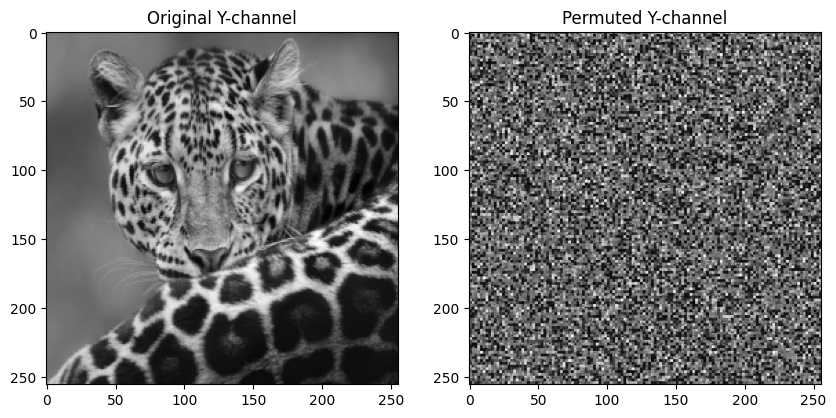

In [70]:
img = Image.open("container.jpg")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
img_tensor = transform(img)

img_ycrcb = rgb_to_ycrcb(img_tensor)

# Извлечение Y-канала
y_channel = img_ycrcb[0:1, :, :]  # [1, H, W]

permuter = ChaosPermutation(mu=3.9, x0=0.1)
permuted_y = permuter.permute(y_channel)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(121); plt.title("Original Y-channel")
plt.imshow(y_channel[0], cmap='gray')
plt.subplot(122); plt.title("Permuted Y-channel")
plt.imshow(permuted_y[0], cmap='gray')
plt.show()

In [71]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.alpha = 0.05
        self.split_channels = in_channels // 2
        
        # Для Y-канала (1 channel) и секрета (3 channels)
        self.psi = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )
        
        self.phi = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )

        self.rho = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )
        
        self.eta = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def forward(self, x):
        xh, xs = x[:, :1], x[:, 1:]  # Разделение на cover (1ch) и secret (3ch)
        
        # Прямой проход (формула 6)
        s = torch.sigmoid(self.alpha * self.psi(xs))
        t = self.phi(xs)
        xh_new = s * xh + t
        
        s = torch.sigmoid(self.alpha * self.rho(xh_new))
        t = self.eta(xh_new)
        xs_new = s * xs + t
        
        return torch.cat([xh_new, xs_new], dim=1)
    
    def inverse(self, y):
        xh_new, xs_new = y[:, :1], y[:, 1:]
        
        # Обратный проход (формула 7)
        s = torch.sigmoid(self.alpha * self.rho(xh_new))
        t = self.eta(xh_new)
        xs = (xs_new - t) / (s + 1e-8)
        
        s = torch.sigmoid(self.alpha * self.psi(xs))
        t = self.phi(xs)
        xh = (xh_new - t) / (s + 1e-8)
        
        return torch.cat([xh, xs], dim=1)

In [72]:
class INNBlock(nn.Module):
    """ Полный инвертируемый блок с вейвлет-преобразованием """
    def __init__(self):
        super().__init__()
        self.affine = AffineCouplingLayer(in_channels=64)
        
    def forward(self, x):
        # Прямое преобразование
        return self.affine(x)
    
    def inverse(self, y):
        # Обратное преобразование
        return self.affine.inverse(y)

In [73]:
class HaarWavelet(nn.Module):
    def __init__(self):
        super().__init__()
        # Используем групповые свертки — одна свёртка на канал
        self.weight = torch.tensor([[0.5, 0.5], [0.5, 0.5]], dtype=torch.float32).view(1, 1, 2, 2)
    
    def forward(self, x):
        c = x.shape[1]
        weight = self.weight.expand(c, 1, 2, 2).to(x.device)
        return F.conv2d(x, weight, stride=2, groups=c)

    def inverse(self, x):
        return F.interpolate(x, scale_factor=2, mode='nearest')


In [74]:
class CHASE(nn.Module):
    def __init__(self, num_blocks=16):
        super().__init__()
        self.inn_blocks = nn.ModuleList([INNBlock() for _ in range(num_blocks)])
        self.haar = HaarWavelet()
        self.sigmoid = nn.Sigmoid()
        
    def forward_hide(self, cover, secret):
        # Конкатенация cover (1ch) + secret (3ch)
        x = torch.cat([cover, secret], dim=1)
        
        # Haar Wavelet Transform
        x = self.haar(x)
        
        # INN блоки
        for block in self.inn_blocks:
            x = block(x)
            
        stego, r = x[:, :1], x[:, 1:]
        return self.sigmoid(stego), r
    
    def forward_reveal(self, stego, z):
        x = torch.cat([stego, z], dim=1)
        
        # Обратные INN блоки
        for block in reversed(self.inn_blocks):
            x = block.inverse(x)
            
        # Обратное Haar преобразование
        x = self.haar.inverse(x)
        
        return x[:, :1], x[:, 1:]

In [75]:
def hiding_loss(cover, stego):
    """ Потеря скрытия: L_hid """
    return torch.nn.functional.mse_loss(cover, stego)

def reconstruction_loss(secret, secret_recon):
    """ Потеря восстановления: L_rec """
    return torch.nn.functional.l1_loss(secret, secret_recon)

In [76]:
def prepare_inputs(cover_rgb, secret_rgb, chaos: ChaosPermutation):
    """
    Преобразует cover и secret изображения согласно статье CHASE.
    
    cover_rgb: [3, H, W] — RGB host image
    secret_rgb: [3, H, W] — RGB secret image
    chaos: ChaosPermutation instance
    """
    # 1. Cover image → Y channel
    cover_ycrcb = rgb_to_ycrcb(cover_rgb)
    cover_y = cover_ycrcb[0:1]  # форма: [1, H, W]

    # 2. Secret image → YCrCb
    secret_ycrcb = rgb_to_ycrcb(secret_rgb)

    # 3. Scramble secret image
    secret_ycrcb_scrambled = chaos.permute(secret_ycrcb)

    return cover_y.unsqueeze(0), secret_ycrcb_scrambled.unsqueeze(0)

In [77]:
chaos = ChaosPermutation(mu=3.99, x0=0.314, iterations=1000)
model = CHASE()

cover_rgb = Image.open("container.jpg")
secret_rgb = Image.open("secret.jpg")

cover_rgb = transform(cover_rgb)
secret_rgb = transform(secret_rgb)

cover_y, secret_ycrcb_scrambled = prepare_inputs(cover_rgb, secret_rgb, chaos)
# Скрытие
stego_y, r = model.forward_hide(cover_y, secret_ycrcb_scrambled)

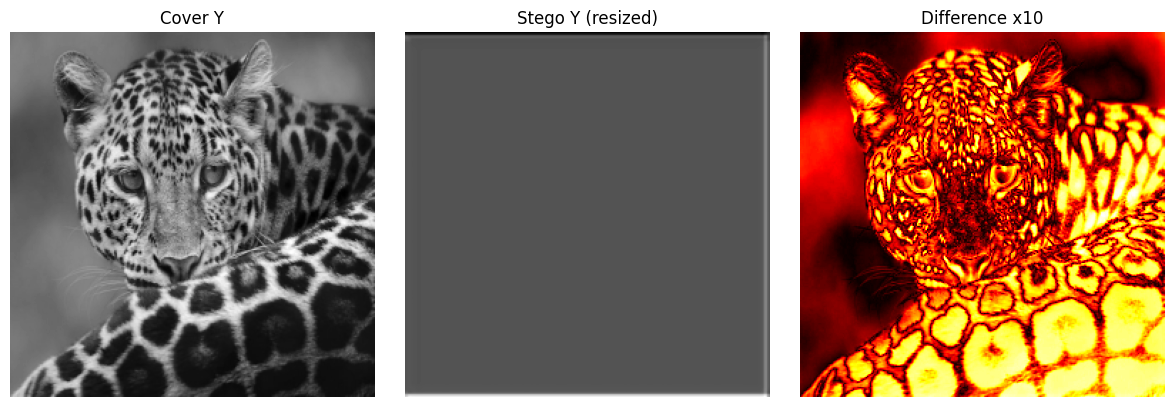

In [78]:
def show_comparison(cov_y, stego_y):
    # Приводим к одинаковому размеру
    stego_resized = F.interpolate(stego_y, size=cov_y.shape[-2:], mode='bilinear', align_corners=False)
    diff = (stego_resized - cov_y).abs() * 10  # Усилим

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(cov_y.squeeze().cpu(), cmap='gray')
    axs[0].set_title('Cover Y')
    axs[1].imshow(stego_resized.squeeze().detach().cpu(), cmap='gray')
    axs[1].set_title('Stego Y (resized)')
    axs[2].imshow(diff.squeeze().detach().cpu(), cmap='hot')
    axs[2].set_title('Difference x10')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_comparison(cover_y, stego_y)

In [79]:
print("Cover Y stats:", cover_y.min().item(), cover_y.max().item())
print("Stego Y stats:", stego_y.min().item(), stego_y.max().item())


Cover Y stats: 0.00230196095071733 0.9798863530158997
Stego Y stats: 0.4854317307472229 0.5095974206924438


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

config = {
    "batch_size": 1,
    "num_epochs": 3000,
    "learning_rate": 1e-4,
    "log_interval": 100,
    "checkpoint_dir": "./checkpoints",
    "data_root": "./dataset"
}

# =============================================
# 1. Датасет и загрузчик данных
# =============================================
class SteganographyDataset(Dataset):
    def __init__(self, root_dir):
        self.root = root_dir
        self.image_pairs = self._load_pairs()
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.chaos = ChaosPermutation()

    def _load_pairs(self):
        """ Возвращает список пар (cover_path, secret_path) """
        pairs = []
        for fname in os.listdir(os.path.join(self.root, "cover")):
            if fname.endswith(".jpg"):
                cover_path = os.path.join(self.root, "cover", fname)
                secret_path = os.path.join(self.root, "secret", fname)
                if os.path.exists(secret_path):
                    pairs.append((cover_path, secret_path))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        cover_path, secret_path = self.image_pairs[idx]
        
        # Загрузка изображений
        cover = Image.open(cover_path).convert("RGB")
        secret = Image.open(secret_path).convert("RGB")
        
        # Преобразования
        cover_tensor = self.transform(cover)
        secret_tensor = self.transform(secret)
        
        # Подготовка входных данных
        cover_y, secret_scrambled = prepare_inputs(
            cover_tensor, 
            secret_tensor,
            self.chaos
        )
        
        return cover_y.squeeze(0), secret_scrambled.squeeze(0)

# =============================================
# 3. Функция обучения
# =============================================
def train_model(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for epoch in range(config["num_epochs"]):
        epoch_loss = 0.0
        
        for batch_idx, (cover, secret) in enumerate(train_loader):
            cover = cover.to(device)
            secret = secret.to(device)
            
            # Прямой проход
            stego, r = model.forward_hide(cover, secret)
            
            # Генерация z (временная реализация)
            z = torch.randn_like(r)
            
            # Обратный проход
            cover_recon, secret_recon = model.forward_reveal(stego, z)
            
            # Расчет потерь
            loss_hid = hiding_loss(cover, stego)
            loss_rec = reconstruction_loss(secret, secret_recon)
            loss = 8 * loss_hid + 1 * loss_rec
            
            # Оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Логирование
            if batch_idx % config["log_interval"] == 0:
                print(f"Epoch: {epoch+1}/{config['num_epochs']} | "
                      f"Batch: {batch_idx}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f}")
                
                # Визуализация прогресса
                if batch_idx == 0:
                    visualize_progress(
                        cover[0].cpu(), 
                        stego[0].detach().cpu(), 
                        secret[0].cpu(), 
                        secret_recon[0].detach().cpu()
                    )
        
        # Сохранение модели
        if (epoch + 1) % 100 == 0:
            save_checkpoint(model, epoch)
            
        print(f"Epoch {epoch+1} completed | Avg Loss: {epoch_loss/len(train_loader):.4f}")

# =============================================
# 4. Вспомогательные функции
# =============================================
def visualize_progress(cover, stego, secret, secret_recon):
    """ Визуализация промежуточных результатов """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    # Cover vs Stego
    axs[0,0].imshow(cover.squeeze(), cmap='gray')
    axs[0,0].set_title('Cover Y')
    axs[0,1].imshow(stego.squeeze(), cmap='gray')
    axs[0,1].set_title('Stego Y')
    
    # Secret vs Reconstructed
    axs[1,0].imshow(secret.permute(1,2,0))
    axs[1,0].set_title('Original Secret')
    axs[1,1].imshow(secret_recon.permute(1,2,0))
    axs[1,1].set_title('Reconstructed Secret')
    
    for ax in axs.flatten():
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

def save_checkpoint(model, epoch):
    """ Сохранение чекпоинта """
    if not os.path.exists(config["checkpoint_dir"]):
        os.makedirs(config["checkpoint_dir"])
    
    path = os.path.join(config["checkpoint_dir"], f"chase_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Checkpoint saved to {path}")

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CHASE().to(device)
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Датасет и загрузчик
dataset = SteganographyDataset(config["data_root"])
train_loader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=1
)

# Обучение
train_model(model, train_loader, optimizer, device)

ValueError: num_samples should be a positive integer value, but got num_samples=0